In [440]:
#Installation of packages
!pip install datefinder

In [441]:
which_model ='FFNN'

In [442]:
#Imports for the negotiation:
import scipy
import pickle

import time
import numpy as np
from pprint import pprint
import random
from random import choices
from copy import deepcopy
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

In [443]:
#Imports for loading models:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [444]:
#Imports for Info extraction:

import datefinder
import datetime
import re
import nltk
from nltk import word_tokenize as tokenize
from nltk import pos_tag as tag
nltk.download('wordnet')

import json

import email
from email import policy


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [445]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
myspacy = spacy.load('en')

In [446]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [447]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [448]:
#load the lookup table:
df_lookup = pd.read_csv('gdrive/My Drive/Preferences/lookup.csv')
df_lookup =df_lookup.drop(columns=['Unnamed: 0'])

In [449]:
#Load the vocabulary
vocab_obj = torch.load( 'gdrive/MyDrive/Enron/vocab_obj.pth')

In [450]:

infile = open('gdrive/MyDrive/Enron/vectorizer.pickle','rb')
vectorizer = pickle.load(infile)

**LOADING THE MODELS**

In [451]:
#load the preference network:

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3, padding= 1) #7x24 -> 7x24
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, (5, 7)) #7X24 -> 3X20
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(1728, 84)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 18)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [452]:
output_size = 18 #0-17 (classes)
epochs = 20
batch_size = 32
learning_rate = 0.001

In [453]:
#load the preference network
model = CNN()
model.load_state_dict(torch.load('gdrive/My Drive/Preferences/CNN/CNN_model_2.pth'))

<All keys matched successfully>

In [454]:
class FFNN(nn.Module):
  '''
  Single layer FFNN with sigmoid output
  '''
  def __init__(self, in_dim, hidden_dim):
    super().__init__()

    self.in_dim = in_dim
    self.hidden_dim = hidden_dim

    self.Net = nn.Sequential(
        nn.Linear(self.in_dim, self.hidden_dim),
        nn.ReLU(),
        nn.BatchNorm1d(self.hidden_dim),
        nn.Linear(self.hidden_dim, 1),
        nn.Sigmoid(),
        
    )

  def forward(self, input):
    pred = self.Net(input)
    return pred.view(-1)

In [455]:
in_feattures = 41540
hidden_dim = 64
num_epochs = 10

model_FFNN = FFNN(in_feattures, hidden_dim)
model_FFNN.to(device)


FFNN(
  (Net): Sequential(
    (0): Linear(in_features=41540, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [456]:
model_FFNN.load_state_dict(torch.load('gdrive/MyDrive/Enron/FFNN_model.pth',map_location=torch.device('cpu')))


<All keys matched successfully>

In [457]:
model_FFNN.to(device)

FFNN(
  (Net): Sequential(
    (0): Linear(in_features=41540, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [458]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx =
                                      pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first = True)
        
        self.fc = nn.Linear(2*hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, inp, inp_len):
        
        input_seq = self.embedding(inp)
        
        #Pack a Tensor containing padded sequences of variable length:
        packed_seq = nn.utils.rnn.pack_padded_sequence(input_seq, inp_len.cpu(),
                                                       batch_first=True)
        
        packed, (hidden_state, c_state) = self.rnn(packed_seq)

       
        hidden_state = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]),
                                 dim = 1)
        h2o = self.fc(hidden_state)
        output = self.dropout(h2o)
                
            
        return output

In [459]:
num_epochs = 20
batch_size = 64
learning_rate = 0.001
vocab_size = len(vocab_obj)

#embedding dimension
embedding_dim = 100
hidden_dim = 128
out_dim = 1
num_layers = 2
is_bidir = True
dropout= 0.3
padding_index = 1

In [460]:
model_LSTM = LSTM(vocab_size, 
            embedding_dim, 
            hidden_dim, 
            out_dim, 
            num_layers, 
            is_bidir, 
            dropout, 
            padding_index)

In [461]:
model_LSTM.load_state_dict(torch.load('gdrive/MyDrive/Enron/LSTM_model.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [462]:
def predict_preference(in_model, in_array, lookup, print_on):
  '''
  function that takes NN model and 7*24 calendar and tags it with 
  preferences according to lookup table
  '''
  test_sample = torch.FloatTensor(in_array.tolist())

  
  in_model.eval()
  with torch.no_grad():
    test_var = Variable(test_sample)
    test_var = test_var.unsqueeze(0)

    net_out = in_model(test_var.unsqueeze(0))
    test_pred = torch.max(net_out.data, 1)[1].numpy()
    predicted_label = test_pred.item()

    lookup_row = lookup[lookup['lbl_concat'] == predicted_label]
    w = lookup_row['Week'].item()
    d = lookup_row['Day'].item()
    b = lookup_row['b2b'].item()
    if print_on:

      print(100*'-')
      print('Predictions:')
      print(100*'-')
      print()
      print('Predicted Label:',predicted_label)
      print('Time of week preference:', w)
      print('Time of day preference:', d)
      print('Back to back meetings (True/False):', b)
      print()
      print(100*'-')
      print()
      print(100*'-')

    return test_pred.item(), w, d, b

In [463]:

def predict_meeting_request(in_model, input_seq, vocab):
  '''
  takes in text, NLP model and vocabulary and predicts
  whether input sequence contains meeting request
  '''
  
  in_model.eval()
  with torch.no_grad():
    tokenized_sequence = [token.text for token in myspacy.tokenizer(input_seq)] 
    #print(tokenized) #tokenize the sentence 
    w2i = [vocab.stoi[t] for t in tokenized_sequence]
    #print(indexed)         
    sequence_length = [len(w2i)]                                   
    tensor = torch.LongTensor(w2i).to(device) 
    #print(tensor)             
    tensor = tensor.unsqueeze(1).T  
    #print(tensor)
    #print(tensor.shape)                        
    length_tensor = torch.LongTensor(sequence_length)  
    #print(length_tensor)              
    prediction = in_model(tensor, length_tensor).squeeze() 
    #print(prediction)
    out = torch.round(torch.sigmoid(-prediction))        
    return out.item()       

**INFO EXTRACTION**

In [464]:
def process_text(text, stemming=False, lemmatization=True,
                 additional_stopwords = []):
    '''
    preprocess text by stemming or lemmatizing and removing stopwords
    
    '''
    unwanted_seqs = ['calendar entry appointment description tms weekly',
                     'calendar entry appointment description team leader ',
                     'calendar entry appointment description',
                     'calendar entry appointment team leader',
                     'calendar entry appointment',
                     'chairperson outlook migration team detailed',
                     'inline attachment follows'
                     ]
    stemmer = nltk.stem.porter.PorterStemmer()
    lemmer = nltk.stem.wordnet.WordNetLemmatizer()


    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d{9,}', '', str(text).lower().strip())
    text = re.sub(r"http\S+","URL", str(text).lower().strip())

            
    ## Tokenize (convert from string to list)
    text_list = text.split()
    
    ## remove Stopwords
    stopwords = list(en_stop) + additional_stopwords
    text_list = [word for word in text_list if word not in stopwords]
                
    if stemming:
      lst_text = [stemmer.stem(word) for word in text_list]
                
    ## Lemmatisation (convert the word into root word)
    if lemmatization:
      lst_text = [lemmer.lemmatize(word) for word in text_list]
    
    ## back to string from list
    output = " ".join(text_list)

    for seq in unwanted_seqs:
      if seq in output:
        output = re.sub(seq, '', str(output).lower().strip())
    
    return output

In [465]:
sorted_months = ["january", "february", "march", "april", "may", "june","july",
          "august", "september","october","november", "december"]
sorted_days = ["monday", "tuesday", "wednesday", "thursday", "friday",
        "saturday", "sunday"]
ordinal_numbers = ["rd", "th", "st", "nd"]
numbers_list = ['one', 'two', 'three', 'four', 'five',
                'six', 'seven', 'eight', 'nine']

def date_from_text(input_string):
    '''
    get datetime() date information from raw text
    '''
    
    text = input_string.lower()
    today = datetime.date.today()

    # If today is in text:
    if text.count("today") > 0:
        return today

    #if tomorrow is in text:
    if text.count("tomorrow") > 0 or text.count("tmr") > 0:
        return today + datetime.timedelta(1)

    #For the case where we have in _ days/weeks
    if bool(re.search(r'in\s(\d+|one|two|three|four|five|six|seven|eight|nine)\s(days|weeks|week)', text)):
      x = re.search(r'in\s(\d+|one|two|three|four|five|six|seven|eight|nine)\s(days|weeks|week)', text)
      match = x.group()
      n = match.split()[-2]
      if n in numbers_list:
        num = numbers_list.index(n)+1
      else:
        num = int(n)

      if match.split()[-1] == 'days':
        return today + datetime.timedelta(num)
      else:
        return today + datetime.timedelta(num*7) 

    

    day, month, day_idx = -1,-1,-1
    year = today.year

    for token in text.split():
      #regualar expression for abreviated months:
      if bool(re.search(r'jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?', token)):
        match = re.findall(r'jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?', token)[0]
        #print(match)

        #find corresponding month index
        for m in sorted_months:
          if match in m:
            month = sorted_months.index(m) + 1
            #print(month)
        
      elif bool(re.search(r'\b((mon|tues|wed(nes)?|thur(s)?|fri|sat(ur)?|sun)(day)?)\b', token)):

        match = re.findall(r'\b((mon|tues|wed(nes)?|thur(s)?|fri|sat(ur)?|sun)(day)?)\b', token)[0][0]
        
        #find corresponding day index
        for d in sorted_days:
          if match in d:
            day_idx = sorted_days.index(d)
      
      elif token in sorted_days:
        day_idx = sorted_days.index(token)

      elif token.isdigit():
        day = int(token)
        
      else:
        for ordinal in ordinal_numbers:
          found = token.find(ordinal)
          if found > 0:
            try:
              day = int(token[:found])
            except:
              pass

    #If the given month has passed go to the next year
    if month < today.month and month != -1:  
      year = year+1
    
    #If we are given the current month but day has passed
    #go to the next year 
    if month == today.month and day !=-1:
      if day < today.day:
        year = year+1

    #if month is not present:
    if month == -1 and day != -1:  
      #if day is less than current day go to next month
      if day < today.day:
        month = today.month + 1
      
      else:
        month = today.month

    
    if month == -1 and day == -1 and day_idx != -1:
      today_idx = today.weekday()
      difference = day_idx - today_idx

      if difference < 0:
        difference += 7
        if text.count("next") >= 1:
          difference += 7

      return today + datetime.timedelta(difference)

    if day != -1:  
      return datetime.datetime(month=month, day=day, year=year)
    
    else:
      matches = datefinder.find_dates(input_string)
      for match in matches:
        return match.date()
      

In [466]:
def time_from_text(input_string):
  '''
  get time information from raw text
  '''
  
  if bool(re.search(r'(([0-1]{0,1}[0-9]( )?(AM|am|aM|Am|PM|pm|pM|Pm))|(([0]?[1-9]|1[0-2])(:|\.)[0-5][0-9]( )?(AM|am|aM|Am|PM|pm|pM|Pm))|(([0]?[0-9]|1[0-9]|2[0-3])(:|\.)[0-5][0-9]))', input_string)):
    match = re.findall(r'(([0-1]{0,1}[0-9]( )?(AM|am|aM|Am|PM|pm|pM|Pm))|(([0]?[1-9]|1[0-2])(:|\.)[0-5][0-9]( )?(AM|am|aM|Am|PM|pm|pM|Pm))|(([0]?[0-9]|1[0-9]|2[0-3])(:|\.)[0-5][0-9]))', input_string)[0][0]
    match = match.lower()

    match_list = match.split()
    #print(match_list)
    
    if len(match_list) == 1:
      
      if 'pm' in match:
        
        i = match.index('pm')
        num = match[:i]
        
        if ':' in num:
          split = num.split(':')
          hours = int(split[0]) + 12
          minutes = int(split[1])
      
        else:
          hours = int(num) + 12
          minutes = 0
      
      elif 'am' in match:
        i = match.index('am')
        num = match[:i]
        
        if ':' in num:
          split = num.split(':')
          hours = int(split[0])
          minutes = int(split[1])
        else:
          hours = int(num)
          minutes = 0
      
      else:
        split = match.split(':')
        hours = int(split[0])
        minutes = int(split[1])
      
    elif len(match_list) == 2:
      
      if ':' in match_list[0]:
        
        split = match_list[0].split(':')
        hours = int(split[0])
        minutes = int(split[1])
     
      else:
        hours = int(match_list[0])
        minutes = 0
      
      if match_list[-1] == 'pm':
        hours += 12

        
  else:
    
    print('No time in string')
    return None
  #print('Hours:',hours)
  #print('Minutes:', minutes)
  timeobj = datetime.time(hours, minutes)
  return timeobj




In [467]:
def get_slot_from_datetime(time, date):

  '''
  accepts time in 24h format and date
  returns timeslot
  '''
  hour_lst = str(time).split(':')
  day_slot = int(hour_lst[0])
  #isoweekday() -> Monday = 1 ...  Sunday  = 6
  day_idx = date.isoweekday() % 7 
  timeslot = day_slot+24*day_idx
  return timeslot


**NEGOTIATION**


In [468]:
#################################################################
###                  INITIAL PARAMETERS                       ###
#################################################################


#meeting_duration = 1
#min_attendees_per_meeting = 2
#num_workdays = 5
#len_workday = 5
num_agents = 5
#num_timeslots = num_workdays*(len_workday//meeting_duration)

#################################################################
###                  INITIAL PARAMETERS                       ###
#################################################################



In [469]:
def create_week_dict(day_start, day_end, num_slots):
  
  keys = [i for i in range(num_slots)]
  week = {key: {'day': None, 'available': None} for key in keys}
  
  available_slots =[i for i in range(day_start, day_end)]
  all_available_slots = []
  for i in range(7):
    new_list = [x+24*i for x in available_slots]
    all_available_slots += new_list
  
  idx = 0
  
  for key in keys:
    if key in all_available_slots:
       week[key]['available'] = True
    else:
       week[key]['available'] = False

    if key in range(idx,idx+24):
      week[key]['day'] = 'Sunday'
    if key in range(idx+24,idx+24*2):
      week[key]['day'] = 'Monday'
    if key in range(idx+24*2,idx+24*3):
      week[key]['day'] = 'Tuesday'
    if key in range(idx+24*3,idx+24*4):
      week[key]['day'] = 'Wednesday'
    if key in range(idx+24*4,idx+24*5):
      week[key]['day'] = 'Thursday'
    if key in range(idx+24*5,idx+24*6):
      week[key]['day'] = 'Friday'
    if key in range(idx+24*6,idx+24*7):
      week[key]['day'] = 'Saturday'
  return week

In [470]:
# week_dict = create_week_dict(5,23,168)

In [471]:
def create_agents_week(num_agents, percentage_busy, week_dict):
  '''
  creates a dictionary of agents
  each has a unique id, a calendar, and a number of meetings
  num_agents: number of agents to create
  percentage_busy: how many of them should be deemed as busy
  num_timeslots: how many timeslots should their calendar have
  '''

  agents = dict()
  population = [0,1]
  weights = (1-percentage_busy, percentage_busy)
  for i in range(num_agents):
    idx = choices(population,weights)[0]
    
    if idx == 1:
      agents.update({'A%i'%i:{'calendar':{'%i'%i:{'meeting':'No Meeting','status':None, 'day':week_dict[i]['day'], 'available': week_dict[i]['available']}for i in range(168)},'busy':True, 'num_meetings': 0}})
    
    elif idx == 0:
      agents.update({'A%i'%i:{'calendar':{'%i'%i:{'meeting':'No Meeting','status':None, 'day':week_dict[i]['day'], 'available': week_dict[i]['available']}for i in range(168)},'busy':False, 'num_meetings': 0}})


  
  return agents

    

In [472]:
# all_agents_full = create_agents_week(num_agents, 0.5,week_dict)

In [473]:
def get_free_slots(dictionary, idx):
  '''
  function that returns free slots for given attendee
  used when populating initial calendar
  '''
  available_slots = []
  for key in dictionary[idx]['calendar'].keys():
    if dictionary[idx]['calendar'][key]['day'] != 'Saturday' and dictionary[idx]['calendar'][key]['day'] != 'Sunday':
      if dictionary[idx]['calendar'][key]['meeting'] == 'No Meeting' and dictionary[idx]['calendar'][key]['available']:
        available_slots.append(key)
  return available_slots


In [474]:
def get_free_slots_2(m_dict, attendee):
  '''
  function that gets free slots for attendee
  adapted for negotiation protocol
  '''
  available_slots =[i for i in range(5, 23)]
  all_available_slots = []
  for i in range(1,6):
    new_list = [x+24*i for x in available_slots]
    all_available_slots += new_list
 
  #print('available slots:', available_slots)
  #print('num available slots:', len(available_slots))
  for key in m_dict.keys():
    if attendee in m_dict[key]['attendees']:
      for tuple in m_dict[key]['timeslots']:
        if int(tuple[0]) in all_available_slots:
          all_available_slots.remove(int(tuple[0]))

  return all_available_slots

In [475]:
def create_meetings(agents, num_slots, density_busy, density_not_busy,
                    min_attendees, max_attendees):
  '''
  function that creates meetings and populates calendars of attendees
  agents: dictionary
  num_slots = number of available slots
  density_busy: How dense should a busy persons calendar be
  density_not_busy: How dense should a not busy persons calendar be
  min, max attendees: minimum and maximum attendees for each meeting
  '''
  #empty dict for meetings:
  meetings = dict()
  count = 0
  #how many meetings busy and non busy individuals should have according to
  #percentages:
  num_meetings_busy = int(num_slots*density_busy)
  num_meetings_not_busy = int(num_slots*density_not_busy)

  #get list of agent ids:
  agent_list = list(agents.keys())
  
  #while the above list is not empty
  while len(agent_list) >= min_attendees:
    #randomly sample a subset of the attendees within allowed number of attendees:
    num = max_attendees
    if len(agent_list) <= num:
      num = len(agent_list)
    attendees = random.sample(agent_list,random.randint(min_attendees,num))


    all_slots = []
    #for each attendee, add the available slots to a list:
    for attendee in attendees:
      available_slots = get_free_slots(agents, attendee)

      #append free slots for a single attendee to array for all attendees
      all_slots.append(available_slots)
    #find the overlap between the slots for each attendee:
    overlap = set(all_slots[0]).intersection(*all_slots)
    #
    if len(overlap) == 0:
      pass
      #print(attendees)
    #if the overlap is a non empty list, choose a random slot
    else:
      meeting_slot = random.choice(list(overlap))
      #create a meeting for that slot, and add it to the meetings dictionary
      meeting_id = 'M%i'%count
      count += 1
      #randomly assign an initiator
      initiator_idx = random.randint(0,len(attendees)-1)
      meetings.update({meeting_id: {'attendees': attendees, 'timeslot':
                                    meeting_slot, 
                                    'initiator': attendees[initiator_idx], 
                                    'status':'CONFIRMED'}})

      
      #for each attendee in that meeting, update the calendar and the meetings count
      for attendee in attendees:
        agents[attendee]['calendar'][meeting_slot]['meeting'] = meeting_id
        agents[attendee]['calendar'][meeting_slot]['status'] = 'CONFIRMED'
        agents[attendee]['num_meetings']+= 1
        
        #if the attendees have reached their maximum allowed limit of meetings,
        #remove them from available attendees
        if  agents[attendee]['busy'] and agents[attendee]['num_meetings'] == num_meetings_busy:
          agent_list.remove(attendee)
        if  not agents[attendee]['busy'] and agents[attendee]['num_meetings'] == num_meetings_not_busy:
          agent_list.remove(attendee)
        

     
  return meetings

In [476]:
def list_duplicates(seq):
  '''
  function that finds duplicates in a list
  this is implemented for testing reasons
  '''
  tally = defaultdict(list)
  for i,item in enumerate(seq):
      tally[item].append(i)
  return ((key,locs) for key,locs in tally.items() 
                          if len(locs)>1)

In [477]:


def agents_to_dict(a_dictionary):
  '''
  takes agents dictionary and adjusts it for negotiation protocol
  '''

  a_dict = deepcopy(a_dictionary)
  out = {}
  for key in a_dict.keys():
    out.update({key: []})
    for key_2 in a_dict[key]['calendar'].keys():
      if a_dict[key]['calendar'][key_2]['meeting'] != 'No Meeting':
        out[key].append([a_dict[key]['calendar'][key_2]['meeting'], key_2,
                        a_dict[key]['calendar'][key_2]['status']])
  return out

def meetings_to_dict(m_dictionary):
  '''
  takes meetings dictionary and adjusts it for negotiation protocol
  '''
  m_dict = deepcopy(m_dictionary)
  out = {}
  for key in m_dict.keys():
    out.update({key: {'attendees': m_dict[key]['attendees'],
                      'initiator': m_dict[key]['initiator'],
                      'timeslots': []}})
    
    out[key]['timeslots'].append( [m_dict[key]['timeslot'],
                                   m_dict[key]['status']])
  
  return out





In [478]:
def create_preferences_dict(a_dict):
  '''
  takes the dictionary of agaents and returns a corresponding dictionary
  of individual preferences based on their meeting distribution
  '''

  out = {}
  keys_list = list(a_dict.keys())
  for key in keys_list:
    out.update({key:{'calendar': np.zeros((168,)), 'preference': None, 'week': None, 'day': None, 'b2b':None}})
    for t in a_dict[key]:
      out[key]['calendar'][int(t[1])] = 1
    out[key]['calendar_1'] = np.asarray(out[key]['calendar'].reshape((7,24)))

  for key in keys_list:
    
    cal = out[key]['calendar_1']
    pred =  predict_preference(model, cal, df_lookup, False)
    out[key]['preference'] = pred[0]
    out[key]['week'] = pred[1]
    out[key]['day'] = pred[2]
    out[key]['b2b'] = pred[3]

  return out

In [479]:
def create_slot_lookup(day_start, day_end):
  '''
  funtion that tags each timeslot for preferences
  '''
  out = {}
  available_slots =[i for i in range(day_start, day_end)]
  all_available_slots = []

  #all available slots (exclude weekends and sleep times)
  for i in range(1,6):
    new_list = [x+24*i for x in available_slots]
    all_available_slots += new_list
  
  for s in all_available_slots:
    out.update({s:{'Week':None, 'Day': None}})
  
  #get max slot in a week and use it to
  #classify slots
  keys_list = list(out.keys())
  max_key = max(keys_list)

  for key in out.keys():
    #split week in half
    if key <= max_key // 2:
      out[key]['Week'] = 'early'
    else:
      out[key]['Week'] = 'late'
    
    #slit day in half
    if key % 24 < 12:
      out[key]['Day'] = 'early'
    else:
      out[key]['Day'] = 'late'

  return out



In [480]:
def list_intersection(lst1, lst2):
  '''
  helper function that finds list intersection
  '''
  
  lst3 = [value for value in lst1 if value in lst2]
  return lst3

In [481]:
def get_prefered_slot(available_slots, a_dict, agent, pref_dict, slot_lookup):
  '''
  function that takes free slots and checks overlap with preference
  returns a list of prefereed slots
  '''
  
  slots = []
  day_pref = pref_dict[agent]['day']
  week_pref = pref_dict[agent]['week']
  b2b_pref = pref_dict[agent]['b2b']


  
  #print('day_pref:', type(day_pref))
  #print('week_pref:', week_pref)
  #print('b2b_pref:', b2b_pref)

  booked_slots = [str(i[1]) for i in a_dict[agent]]
  
  if day_pref != 'None' and week_pref != 'None':
    #print('both')
    for key in slot_lookup.keys():
      if slot_lookup[key]['Day'] == day_pref and slot_lookup[key]['Week'] == week_pref:
        slots.append(str(key))

  if day_pref != 'None' and week_pref == 'None':
   # print('day')
    for key in slot_lookup.keys():
      if slot_lookup[key]['Day'] == day_pref:
        slots.append(str(key))

  if day_pref == 'None' and week_pref != 'None':
   # print('week')
    for key in slot_lookup.keys():
      if slot_lookup[key]['Week'] == week_pref:
        slots.append(str(key))
  
  if day_pref == 'None' and week_pref == 'None':
    slots = available_slots
    
  out = [str(i) for i in list_intersection(slots, available_slots)]
  
  if b2b_pref:
    b2b_slots = []
    for i in out:
      for j in booked_slots:
        diff = abs(int(i)-int(j))
        if diff == 1 or diff == 2:
          b2b_slots.append(str(i))
    #print('Preferred Slots:', list(set(b2b_slots)))
    # print('booked slots:', booked_slots)
    # print('prefered slots:', out)

    return list(set(b2b_slots))
    
  else:
    #print('Preferred Slots:', out)
    return out
    


In [482]:
def check_for_duplicates(timeslots):
  '''
  function that takes in timeslots for every meeting
  and checks whether there is overlap between attendees
  '''
  duplicate_timeslots = []
  for dup in sorted(list_duplicates(timeslots)):
      duplicate_timeslots.append(dup)
  final = []
  for i in duplicate_timeslots:
    attendees_of_duplicates = []
    for key in m.keys():
      if m[key]['timeslot'] == i[0]:
        attendees_of_duplicates.append(m[key]['attendees'])
    final.append(attendees_of_duplicates)
  for f in final:
     overlap = set(f[0]).intersection(*f)
     if len(overlap) != 0:
       return('MISTAKE')
  return 'NO MISTAKE'


In [483]:
def get_number_from_key(key):
  '''
  helper function to get number in key string
  '''
  l = list(key)
  digits = l[1:]
  new_num = int("".join(digits))
  return new_num


In [484]:
def check(user):
  '''
  takes a user as an input and
  checks whether actual number of meetings matches up 
  to corresponding entry
  '''
  counter = 0
  for key in new_dict_deepcopy[user]['calendar'].keys():
    if new_dict_deepcopy[user]['calendar'][key] != 'No Meeting':
      counter += 1
  if counter ==  new_dict_deepcopy[user]['num_meetings'] == counter:
    return 'CORRECT'
  else:
    return 'WRONG'




In [485]:

def get_new_meeting_id(meeting_ids):
  '''
  takes previous ids, returns new id
  '''
  last_id = list(meeting_ids[-1])
  digits = last_id[1:]
  new_num = int("".join(digits))+1
  new_id = last_id[0]+str(new_num)
  return new_id


In [486]:
def get_meetings_at_t_2(timeslot, m_dict):
  ''' 
  function that returns all meetings
  at timeslot t
  '''
  m_dict_1 = deepcopy(m_dict)
  out = {}
  for key in m_dict_1.keys():
    for tuple in  m_dict_1[key]['timeslots']:
      if tuple[0] == timeslot:
        out.update({key:m_dict_1[key]})
  return out

In [487]:
def bumping_rule_2( attendee,  meeting_in_calendar,meeting_proposed,
                   a_dict, m_dict):
  '''
  function that takes current meeting and proposed meeting and chooses
  whether to bump or not
  '''
  bump = False
  diff_list_1 = []
  diff_list_2 = []
  sum_1 = 0
  sum_2 = 0
  if attendee not in m_dict[meeting_in_calendar]['attendees']:
    return('Wrong Input')
  for att in m_dict[meeting_in_calendar]['attendees']:
    if att != attendee:
      diff_list_1.append(att)
  for att in m_dict[meeting_proposed]['attendees']:
    if att != attendee:
      diff_list_2.append(att)
  for i in diff_list_1:
    sum_1+=  len(a_dict[i])
  for j in diff_list_2:
    sum_2+=  len(a_dict[j])
  if sum_2 > sum_1:
    bump = True
  if print_on:
    print(attendee, 'deciding whether to bump', meeting_in_calendar, 'for',
          meeting_proposed)
    print('Difficulty of', meeting_in_calendar, ':', sum_1)
    print('Difficulty of', meeting_proposed, ':', sum_2)
  return bump

In [488]:
# def create_new_meeting_random_2(num_attendees, a_dict, m_dict):
#   '''
#   takes in meeting arguments, and creates a pending meeting
#   '''
#   meeting_ids = list(m_dict.keys())
#   new_id = get_new_meeting_id(meeting_ids)
#   agent_list = list(a_dict.keys())
#   attendees = random.sample(agent_list,num_attendees)
#   idx = random.randint(0, len(attendees)-1)
#   initiator = attendees[idx]
#   timeslots = get_free_slots_2(m_dict, initiator)
#   if len(timeslots) == 0:
#     return 'No available timeslots for initiator'
#   ##############################################################################
#   preferred_timeslots = get_prefered_slot(timeslots, a_dict, initiator, pref_dict, slot_lookup)
#   global preference_on
#   if preference_on:
#     t_idx = random.randint(0, len(preferred_timeslots)-1)
#     t = preferred_timeslots[t_idx]
#     if print_on:
#       print('Preferred timeslots of intiator:', preferred_timeslots)
#   ##############################################################################
#   else:
#     t_idx = random.randint(0, len(timeslots)-1)
#     t = timeslots [t_idx]
    


#   out = {new_id: {'attendees': attendees, 'initiator': initiator,
#                   'timeslots':[[t, 'PENDING']] }}
#   return out


In [489]:
def create_new_meeting(initiator, attendees, timeslot, m_dict):
  '''
  takes in meeting arguments, and creates a pending meeting
  '''
  meeting_ids = list(m_dict.keys())
  new_id = get_new_meeting_id(meeting_ids)
  
  out = {new_id: {'attendees': attendees, 'initiator': initiator,
                  'timeslots':[[timeslot, 'PENDING']] }}
  return out




In [490]:
def initiate_2_negotiation(initiator, attendees, timeslot, a_dict, m_dict):
  '''
  initiates new meeting with given initiator, attendees and timeslot
  '''
  #create new meeting:
  global round
  round+=1

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')
    print('initiated random meeting')
  
  new_meeting = create_new_meeting(initiator, attendees, str(timeslot), m_dict)

  m_dict.update(new_meeting)
  new_id = list(new_meeting)[0]

  timeslot = new_meeting[new_id]['timeslots'][0][0]
  if print_on:
    print('ID:', new_id)
    print('Proposed timeslot:', timeslot)
    print('initiator:',new_meeting[new_id]['initiator'])
    print('attendees:', new_meeting[new_id]['attendees'])
  #for each attenddee call the next function:
  for attendee in new_meeting[new_id]['attendees']:
    if attendee !=  new_meeting[new_id]['initiator']: 

      receive_propose_2(new_id, attendee, timeslot, a_dict, m_dict)

In [491]:
def meetings_to_plots(meetings_dict, agent_list, shape):
  num_slots = shape[0]*shape[1]
  out = dict()
  last_key = list(meetings_dict.keys())[-1]
  for key in agent_list:
    out.update({key:np.zeros(num_slots)})
  
  for key in meetings_dict.keys():
    for tuple in meetings_dict[key]['timeslots']:
      if tuple[-1] == 'CONFIRMED':
        slot = int(tuple[0])
        for attendee in meetings_dict[key]['attendees']:
          if key == last_key:
            out[attendee][slot] = 1.5
          elif ['IMPOSSIBLE' in tuple for tuple in meetings_dict[key]['timeslots']][0]:
            out[attendee][slot] = 2
          else:
            out[attendee][slot] = 1

      
      else:
        pass
  for key in out.keys():
    out[key] = out[key].reshape(shape)
  return out

From this point onwards, the functions correspond to the pseudocode in the paper

In [492]:
def initiate_2(meeting, a_dict, m_dict):
  '''
  initiates meeting negotiation for pre-defined meeeting
  that already has given attendees and initiator
  '''
  global round
  round+=1
  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')
    print('re-initiate negotiation for meeting', meeting)

  #create new meeting:
  
  initiator = m_dict[meeting]['initiator']
  timeslots = get_free_slots_2(m_dict, initiator)

  if len(timeslots) == 0:
    return 'No available timeslots for initiator'
    
  preferred_timeslots = get_prefered_slot(timeslots, a_dict, initiator, pref_dict, slot_lookup)
  if len(preferred_timeslots) == 0 and preference_on:
    return 'No available timeslots for initiator'
  
  if preference_on:
    t_idx = random.randint(0, len(preferred_timeslots)-1)
    t = preferred_timeslots[t_idx]
    if print_on:
      print('Preferred timeslots:', preferred_timeslots)
  
  else:
    t_idx = random.randint(0, len(timeslots)-1)
    t = timeslots[t_idx]


  m_dict[meeting]['timeslots'].append([str(t), 'PENDING'])
  
  if print_on:
    print('Proposed timeslot:', str(t))
    print('Initiator:', initiator)
    print('attendees:', m_dict[meeting]['attendees'])

  #for each attenddee call the next function:
  for attendee in m_dict[meeting]['attendees']:
    #########################
    if attendee != initiator: 
    #########################
      receive_propose_2(meeting, attendee, str(t), a_dict, m_dict)

In [493]:
def receive_propose_2(meeting, attendee, timeslot, a_dict, m_dict):
  '''
  takes meeting id and proposed timeslot and checks 
  for individual availability of given
  '''
  global round
  global preference_on
  round+=1


  #print('Type', type(timeslot))
  if round >= 20:
    print('**************************************************')
    print('**************************************************')
    print('DEACTIVATING PREFERENCE. ROUNDS HAVE EXCEEDED 20')
    print('**************************************************')
    print('**************************************************')



    preference_on = False

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')


  other_meetings = []
  meetings_at_t = get_meetings_at_t_2(timeslot, m_dict)
  for key in meetings_at_t.keys():

    if key != meeting and attendee in meetings_at_t[key]['attendees']:
      other_meetings.append(key)
  
  if preference_on:
    #############################################################################
    ## PREFERENCES
    #############################################################################
    #timeslots = get_free_slots_2(m_dict, attendee)

    #use the preference dictionary to find the preferred timeslots
    #of the specific attendee:

    available_slots =[i for i in range(5, 23)]
    all_available_slots = []
    for i in range(1,6):
      new_list = [str(x+24*i) for x in available_slots]
      all_available_slots += new_list

    preferred_timeslots_attendee = get_prefered_slot(all_available_slots, a_dict, attendee,
                                            pref_dict, slot_lookup)
    if print_on:
      print('preferred timeslots of', attendee, ':')
      print(preferred_timeslots_attendee)
    
    #############################################################################
    #############################################################################


    if len(other_meetings) != 0:
      print('other meetings of', attendee,'at', timeslot, ':')
      print(other_meetings)

      for key in other_meetings:

        #if the specific meeting is pending, reply impossible:
        for tuple in m_dict[key]['timeslots']:
          if print_on:
            print('Status of timeslot', timeslot, 'of',
                  attendee,'before editing:',key,'-',tuple[1])
          if tuple[0] == timeslot and tuple[1] == 'PENDING':
            reply =  'IMPOSSIBLE'
        
        #if the meeting is already confirmed check the bumping rule: 
          elif tuple[0] == timeslot and tuple[1] == 'CONFIRMED' and timeslot in preferred_timeslots_attendee:
            
          #if the bumping rule holds, bump current
          # meeting and add pending to new
            if bumping_rule_2(attendee, key, meeting, a_dict, m_dict):

              tuple[1] = 'BUMPED'
              print(attendee,'bumped', key, 'for',meeting)
              for tuple_2 in m_dict[meeting]['timeslots']:
                if tuple_2[0] == timeslot:
                  tuple_2[1] = 'PENDING'
              reply = 'PENDING'
          
            else:
              if print_on:
                print(attendee,'did not bump', key, 'for', meeting)
              reply = 'IMPOSSIBLE'

          elif tuple[0] == timeslot and tuple[1] == 'CONFIRMED' and timeslot not in preferred_timeslots_attendee:

            if print_on:
              print(attendee,'did not bump', key, 'since they do not prefer that slot')
            reply = 'IMPOSSIBLE'
          
        
          #cover the BUMPED case
          # elif tuple[0] == timeslot and tuple[1] == 'BUMPED' and timeslot in preferred_timeslots_attendee:
          #   if print_on:
          #     print(attendee,'has a bumped meeting at that timeslot')
          #   reply = 'PENDING'
          
          # elif tuple[0] == timeslot and tuple[1] == 'BUMPED' and timeslot not in preferred_timeslots_attendee:
          #   reply = 'IMPOSSIBLE'
          
          else: #if tuple[0] == timeslot and (tuple[1] == 'BUMPED' or tuple[1] == 'IMPOSSIBLE' or tuple[1] == 'POSSIBLE'):
            if timeslot in preferred_timeslots_attendee:
              reply =  'PENDING'
            else:
              reply = 'IMPOSSIBLE'
            



    ### BUMPED case not covered? ###
    #if there is no meeting at that timeslot, reply pending
    else:
      if print_on:
        print(attendee, 'has no meeting at that timeslot')
      if timeslot in preferred_timeslots_attendee:
        if print_on:
          print('The proposed timeslot is within the prefered slots of', attendee)
        for tuple_2 in m_dict[meeting]['timeslots']:
          if tuple_2[0] == timeslot:
            tuple_2[1] = 'PENDING'


        reply = 'PENDING'

      else:
        if print_on:
          print(attendee,'does not prefer timeslot', timeslot, 'for', meeting)
        reply = 'IMPOSSIBLE'


################################################################################
################################################################################

  else:
    if len(other_meetings) != 0:
      if print_on:
        print('other meetings of', attendee,'at', timeslot, ':')
        print(other_meetings)

      for key in other_meetings:

        #if the specific meeting is pending, reply impossible:
        for tuple in m_dict[key]['timeslots']:
          if print_on:
            print('Status of timeslot', timeslot, 'of',
                  attendee,'before editing:',key,'-',tuple[1])
          if tuple[0] == timeslot and tuple[1] == 'PENDING':
            reply =  'IMPOSSIBLE'
        
        #if the meeting is already confirmed check the bumping rule: 
          elif tuple[0] == timeslot and tuple[1] == 'CONFIRMED':

          #if the bumping rule holds, bump current
          # meeting and add pending to new
            if bumping_rule_2(attendee, key, meeting, a_dict, m_dict):

              tuple[1] = 'BUMPED'
              if print_on:
                print(attendee,'bumped', key, 'for',meeting)
              for tuple_2 in m_dict[meeting]['timeslots']:
                if tuple_2[0] == timeslot:
                  tuple_2[1] = 'PENDING'
              reply = 'PENDING'
          
            else:
              if print_on:
                print(attendee,'did not bump', key, 'for', meeting)
              reply = 'IMPOSSIBLE'
          
          #cover the BUMPED case
          else: #if tuple[0] == timeslot and (tuple[1] == 'BUMPED' or tuple[1] == 'IMPOSSIBLE' or tuple[1] == 'POSSIBLE'):
            if print_on:
              print(attendee,'has a', tuple[1], 'meeting at that timeslot')
            reply =  'PENDING'

    ### BUMPED case not covered? ###
    #if there is no meeting at that timeslot, reply pending
    else:
      if print_on:
        print(attendee,'has no other meetings at', timeslot)
      for tuple_2 in m_dict[meeting]['timeslots']:
        if tuple_2[0] == timeslot:
          tuple_2[1] = 'PENDING'


      reply = 'PENDING'


    
  if print_on:
    print('Attendee', attendee, 'replied',reply)

  receive_reply_2(meeting, str(timeslot), reply, attendee,  a_dict, m_dict)

In [494]:
 def receive_reply_2(meeting, timeslot, reply, attendee, a_dict, m_dict):

  '''
  function that takes the replies of attendees for proposed meeting
  and checks for possible intersection.
  If not new timeslot is proposed
  '''
  global round
  round+=1
  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')
  reply_list = []
  a_dict[attendee].append([meeting, timeslot, reply])

  if print_on:
    print('initiator',m_dict[meeting]['initiator'],
          'received reply from', attendee )
  
  for attendee in m_dict[meeting]['attendees']:
    ############################################
    if attendee != m_dict[meeting]['initiator']:
      ##########################################
      for tuple in a_dict[attendee]:
        if tuple[0] == meeting and tuple[1] == timeslot:
          reply_list.append(tuple[2])
    
  #print(reply_list)
  ##########################################################
  if len(reply_list) == len(m_dict[meeting]['attendees'])-1:
  ##########################################################
    if print_on:
      print('All attendees have replied')
      print()
    
    t_list = []
    s_list = []

    for attendee in m_dict[meeting]['attendees']:
      if attendee != m_dict[meeting]['initiator']:

        for tuple in a_dict[attendee]:
          if tuple[0] == meeting and tuple[1] == timeslot:
            t_list.append(tuple)
            s_list.append(tuple[2])
    
    if print_on:
      print('collected replies list:')
      print()
      print(s_list)
      print()
    
    if len(set(s_list)) == 1 and s_list[0] == 'PENDING':
      
      t_dash = str(t_list[0][1])

      if print_on:
        print('confirmed timeslot:', t_dash, 'for', meeting)
      
      for tuple in m_dict[meeting]['timeslots']:
        if tuple[0] == t_dash:

          tuple[1] = 'CONFIRMED'
          resolved_2(meeting, a_dict, m_dict)

          if print_on:
            print('attendees of', meeting, m_dict[meeting]['attendees'])
          
          for attendee in m_dict[meeting]['attendees']:
            ###########################################
            if attendee != m_dict[meeting]['initiator']:
              if print_on:
                print('send confirm to attendee', attendee)
                print()
              receive_confirm_2(meeting, str(t_dash), attendee, a_dict, m_dict)
            ###########################################
            
            
          
          for key in m_dict.keys():

            for tuple_2 in m_dict[key]['timeslots']:
              if tuple_2[0] == t_dash and tuple_2[1] == 'BUMPED':
                if print_on:
                  print('reschedule ',key)
                #return 'Reschedule'
                ##################################################
                reschedule_2(key, m_dict[key]['initiator'], a_dict, m_dict)
                ##################################################
      
    else:

      free_slots = get_free_slots_2(m_dict, m_dict[meeting]['initiator'])
      
      #if no free slot is found send fail
      if len(free_slots) == 0:
        if print_on:
          print('null')
        
        #############################################
        resolved_2(meeting, a_dict, m_dict)
        for attendee in m_dict[meeting]['attendees']:
          if attendee != m_dict[meeting]['initiator']:
            receive_fail_2(meeting, attendee, a_dict, m_dict)

            if print_on:
              print('send meeting', meeting, 'FAILED to', attendee)
        #############################################

      
      else:

        #find new timeslot
        t_idx = random.randint(0, len(free_slots)-1)
        t_dash_dash = free_slots[t_idx]
        if print_on:
          print('alternative timeslot for', meeting, ':', t_dash_dash)

        for key in m_dict.keys():

          if key == meeting:
            m_dict[key]['timeslots'].append([str(t_dash_dash), 'PENDING'])####################

            for attendee in m_dict[key]['attendees']:
              if attendee != m_dict[meeting]['initiator']:

                #propose alternative timeslot to attendees
                if print_on:
                  print('propose alternative slot to', attendee)
                receive_propose_2(meeting, attendee,
                                  str(t_dash_dash), a_dict, m_dict)
              
             
    
  else:
    pass
                                              








In [495]:
def receive_confirm_2(meeting, timeslot, attendee, a_dict, m_dict):
  '''
  function for changing status of confirmed meeting
  '''
  global round
  round+=1

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')  
    print(attendee, 'receiving confirmation for', meeting)
  
  for tuple in m_dict[meeting]['timeslots']:
    if tuple[0] == timeslot:
      tuple[1] = 'CONFIRMED'
      resolved_2(meeting, a_dict, m_dict)
  
  for key in m_dict.keys():
    for tuple_2 in m_dict[key]['timeslots']:
      if tuple_2[0] == timeslot and tuple_2[1] == 'BUMPED':
        reschedule_2(key, attendee, a_dict, m_dict)

In [496]:
def receive_fail_2(meeting, attendee, a_dict, m_dict):
  
  global round
  round+=1

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')
    print('attendee', attendee, 'received fail for', meeting)
    
  resolved_2(meeting, a_dict, m_dict)

In [497]:
def receive_reschedule_2(meeting, attendee, a_dict, m_dict):
  
  global round
  round+=1

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------') 
    print(attendee, 'received reschedule')
  reschedule_2(meeting, attendee, a_dict, m_dict)

In [498]:
def reschedule_2(meeting, attendee, a_dict, m_dict):
  '''
  function that reschedules meeting
  '''
  global round
  round+=1

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')

    print('rescheduling', meeting)
  
  initiator = m_dict[meeting]['initiator']
  attendees = m_dict[meeting]['attendees']
  
  if initiator == attendee:
    if print_on:
      print(attendee, 'is the initiator')
      
    for tuple in m_dict[meeting]['timeslots']: ### was key
      if tuple[1] == 'BUMPED' or tuple[1] == 'CONFIRMED':
        if print_on:
          print('Changing the status of', meeting, 'at', tuple[0], 'from',
                tuple[1], 'to IMPOSSIBLE')
        tuple[1] = 'IMPOSSIBLE'

    
    for attendee in m_dict[meeting]['attendees']:
      if attendee != m_dict[meeting]['initiator']:

        for tuple_2 in a_dict[attendee]:
          if tuple_2[2] == 'IMPOSSIBLE' or tuple_2[2] == 'PENDING':
            tuple_2[2] = 'POSSIBLE'
    
    initiate_2(meeting, a_dict, m_dict)
  
  else:
    receive_reschedule_2(meeting, initiator, a_dict, m_dict)



In [499]:
def resolved_2(meeting, a_dict, m_dict):
  '''
  final function that resolves meetings that
  are either confirmed or failed
  '''
  global round
  round+=1

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')

    print('resolving', meeting)

  for key in m_dict.keys():
    if key == meeting:
      for tuple in m_dict[meeting]['timeslots']:
        if tuple[1] == 'PENDING':
          slot = tuple[0]
          tuple[1] = 'POSSIBLE'

          if print_on:
            print('changed status of', meeting,
                  'at', slot, 'from PENDING to POSSIBLE')

          for key in m_dict.keys():
            for tuple_2 in m_dict[key]['timeslots']:
              if tuple_2[0] == slot and tuple_2[1] == 'BUMPED':
                tuple_2[1] = 'CONFIRMED'

                if print_on:
                  print('changed status of', meeting, 'at',
                        slot, 'from BUMPED to CONFIRMED')
          


In [500]:

def get_confirmed_meetings_at_t(timeslot, m_dict):
  ''' 
  function that returns all meetings
  at timeslot t
  '''
  m_dict_1 = deepcopy(m_dict)
  out = {}
  for key in m_dict_1.keys():
    for tuple in  m_dict_1[key]['timeslots']:
      if tuple[0] == timeslot and tuple[1] == 'CONFIRMED':
        out.update({key:m_dict_1[key]})
  return out



In [501]:
def check_for_overlaps(m_dict):
  '''
  function that checks whether attendees have more
  than one meeting in the same timeslot
  '''

  overlap_count = 0
  timeslots = [str(i) for i in range(168)]
  confirmed_meetings_at_t = []

  for t in timeslots:
    confirmed_meetings_at_t.append(get_confirmed_meetings_at_t(t, m_dict))

  double_confirmed_meetings_at_t = []
  for i in confirmed_meetings_at_t:
    if len(i) > 1:
      double_confirmed_meetings_at_t.append(i)

  attendees_in_doubles = {}

  for d in double_confirmed_meetings_at_t:

    d_list = []
    for key in d.keys():
      d_list.append(set(d[key]['attendees']))

    for key in d.keys():

      for t in d[key]['timeslots']:
        if t[1] == 'CONFIRMED':
          key_2 = t[0]
          break
    
    attendees_in_doubles.update({key_2:d_list})  

  print('attendees in each timeslot:')
  print()
  print(attendees_in_doubles)
  print()
  for key in attendees_in_doubles.keys():
    lst = attendees_in_doubles[key]
    overlap = lst[0].intersection(*lst)
    if len(overlap) != 0:
      overlap_count += 1
      print('Overlap at timeslot', key)

  if overlap_count == 0:
    return 'Correct, no overlap found'
  else:
    return 'Overlaps found'


In [502]:
week_dict = create_week_dict(5,23,168)
all_agents_full = create_agents_week(num_agents, 0.5,week_dict)

In [503]:
#create a copy of the agent dictionary and use it to create meetings:
day_start = 5
day_end = 23
num_slots = (day_end-day_start)*5
new_dict_deepcopy = deepcopy(all_agents_full)
m = create_meetings(new_dict_deepcopy,num_slots,0.5,0.3,2,5)

In [504]:
#create the meetings dictionary
meetings = meetings_to_dict(m)
meetings_before = deepcopy(meetings)
agents = agents_to_dict(new_dict_deepcopy)

In [505]:
pref_dict = create_preferences_dict(agents)
slot_lookup = create_slot_lookup(5,23)
for key in pref_dict.keys():
  pref_dict[key]['7x24'] = pref_dict[key]['calendar'].reshape((7,24))

In [506]:
print(100*'-')
print('Preference dictionary for agents:')
print(100*'-')
pprint(pref_dict)
print(100*'-')
print(100*'-')

----------------------------------------------------------------------------------------------------
Preference dictionary for agents:
----------------------------------------------------------------------------------------------------
{'A0': {'7x24': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [507]:
cmap = colors.ListedColormap(['purple', 'yellow', 'red','orange'])
bounds=[0,0.5,1,1.5,2,2.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

Calendar for agent A0 :


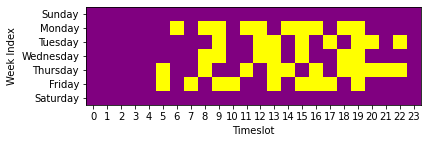

Calendar for agent A1 :


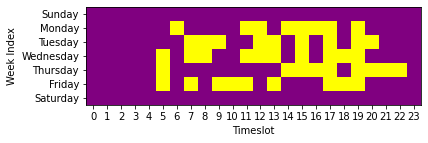

Calendar for agent A2 :


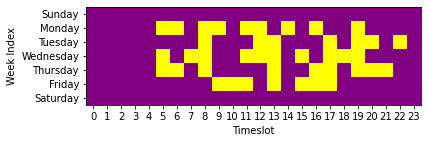

Calendar for agent A3 :


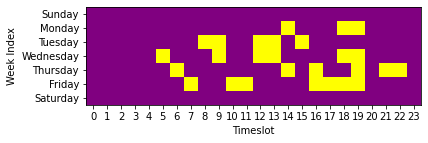

Calendar for agent A4 :


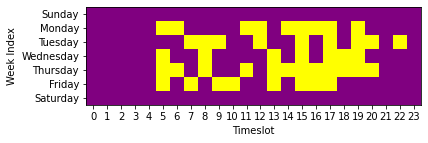

In [508]:
for key in pref_dict.keys():
  print('Calendar for agent',key, ':')
  #plt.imshow(pref_dict[key]['7x24'])
  plt.imshow(pref_dict[key]['7x24'], interpolation='nearest',
                    cmap=cmap, norm=norm)

  plt.yticks(ticks = list(range(7)), labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
  plt.xticks(ticks = list(range(24)),labels =  list(range(24)))
  plt.xlabel('Timeslot')
  plt.ylabel('Week Index')
  plt.show()

In [509]:
#source: https://stackoverflow.com/questions/17874360/python-how-to-parse-the-body-from-a-raw-email-given-that-raw-email-does-not


raw_email = """From A0 Thu Jul 25 19:28:59 2013
Received: from a1.local.tld (localhost [127.0.0.1])
    by a1.local.tld (8.14.4/8.14.4) with ESMTP id r6Q2SxeQ003866
    for <A1,A2>; Thu, 25 Jul 2013 19:28:59 -0700
Received: (from A0)
    by a1.local.tld (8.14.4/8.14.4/Submit) id r6Q2Sxbh003865;
    Thu, 25 Jul 2013 19:28:59 -0700
From: A0
Subject: oooooooooooooooo
To: A1, A2
Cc: 
X-Originating-IP: 192.168.15.127
X-Mailer: Webmin 1.420
Message-Id: <1374805739.3861@a1>
Date: Thu, 25 Jul 2013 19:28:59 -0700 (PDT)
MIME-Version: 1.0
Content-Type: multipart/mixed; boundary="bound1374805739"

This is a multi-part message in MIME format.

--bound1374805739
Content-Type: text/plain
Content-Transfer-Encoding: 7bit


'Hi Robert and Chiraag, can we schedule a meeting on Monday at 5pm to discuss the thesis'


--bound1374805739--"""

In [510]:
message = email.message_from_string(raw_email)
#Person who sent email:
from_who = message['from']

#Recipients:
to_who = message['to']

#Get main body of email:
if message.is_multipart():
  for payload in message.get_payload():
    # if payload.is_multipart(): ...
    body = payload.get_payload()
    print(payload.get_payload())
else:
  body = payload.get_payload()
  print(payload.get_payload())


'Hi Robert and Chiraag, can we schedule a meeting on Monday at 5pm to discuss the thesis'




In [511]:
#Person who sent email is the intiator:
initiator = from_who

#Recipients are assumed to be the remaining attendees:
attendees = to_who.split(',')
for i in range(len(attendees)):
  attendees[i] = attendees[i].strip()

attendees.append(initiator)

print('Initiator:', initiator)
print('Attendees:', attendees)

for attendee in attendees:
  if attendee not in agents.keys():
    raise ValueError('Wrong attendee inputs')

Initiator: A0
Attendees: ['A1', 'A2', 'A0']


In [512]:
#Get available slots of initiator:
initiator_free_slots = get_free_slots_2(meetings, initiator)
print('Free slots of initiator:')
print(initiator_free_slots)

Free slots of initiator:
[29, 31, 34, 37, 41, 44, 45, 46, 53, 54, 55, 56, 58, 59, 62, 64, 66, 69, 77, 78, 79, 82, 83, 86, 88, 89, 92, 93, 94, 102, 103, 105, 106, 108, 111, 113, 126, 128, 131, 132, 134, 138, 140, 141, 142]


In [513]:
#Preprocess main body and check whether it contains meeting request
body_2 = 'Hi Robert, could you please review the attached evaluation report'
body_3 = 'New Calendar entry request for tuesday 10:00'

if which_model == 'LSTM':
  processed_random_text = process_text(body)
  prediction = predict_meeting_request(model_LSTM, processed_random_text, vocab_obj)


elif which_model == 'FFNN':
  vec = vectorizer.transform([body])
  tens1 = torch.tensor(scipy.sparse.csr_matrix.todense(vec)).float()
  with torch.no_grad():
    model_FFNN.eval()
    pr = model_FFNN.forward(tens1)
  prediction = torch.round(pr).item()


#If text contains a meeting request:
if prediction == 0:
  print(100*'-')
  print('String contains meeting request. ')
  print(100*'-')
  print()

  date = date_from_text(body)
  time = time_from_text(body)
  print(100*'-')
  print('Date:', date)
  print(100*'-')
  print()
  print(100*'-')
  print('Time:', time)
  print(100*'-')

elif prediction == 1:
  print('String does not contains meeting request.')
else:
  print('Something wrong')

----------------------------------------------------------------------------------------------------
String contains meeting request. 
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Date: 2021-09-06
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Time: 17:00:00
----------------------------------------------------------------------------------------------------


Timeslot: 41
--------------------------------------------------
ROUND: 1
--------------------------------------------------
initiated random meeting
ID: M59
Proposed timeslot: 41
initiator: A0
attendees: ['A1', 'A2', 'A0']
--------------------------------------------------
ROUND: 2
--------------------------------------------------
preferred timeslots of A1 :
['55', '87', '89', '38', '116', '33', '64', '136', '67', '81', '41', '61', '140', '31', '135', '82', '36', '54', '39', '37', '103', '42', '134', '84', '53', '56', '110', '111', '60', '80', '90', '40', '127', '132', '137', '58', '43', '138', '59', '35', '91', '93', '126', '128', '92', '63', '44', '78', '86', '32', '133', '117', '34', '88', '113', '114', '141', '65', '83', '109', '77', '62', '131', '139', '70', '68', '129', '79', '69', '108', '57', '118', '29', '45', '130', '115', '85', '125', '102', '112', '66']
other meetings of A1 at 41 :
['M31']
Status of timeslot 41 of A1 before editing: M31 - CONFIRMED
A1 deciding whether to b

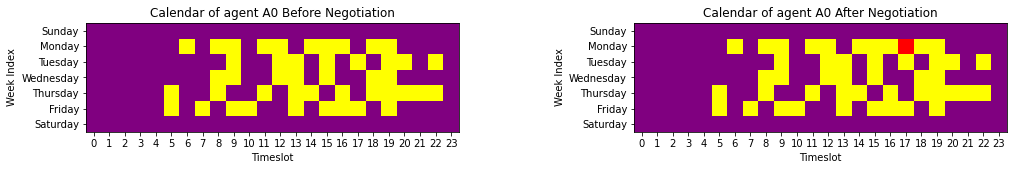

Calendar for agent A1 :


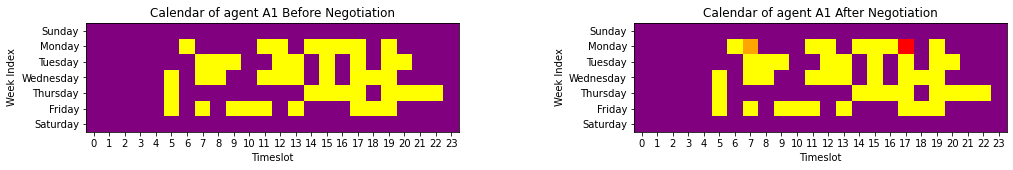

Calendar for agent A2 :


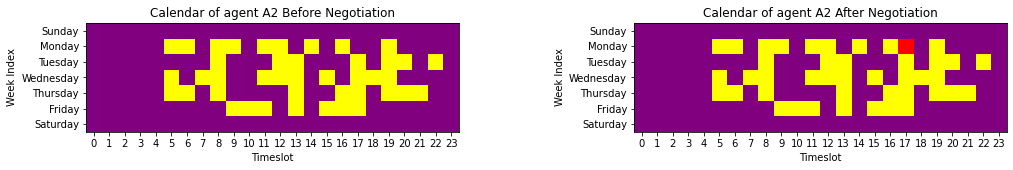

Calendar for agent A3 :


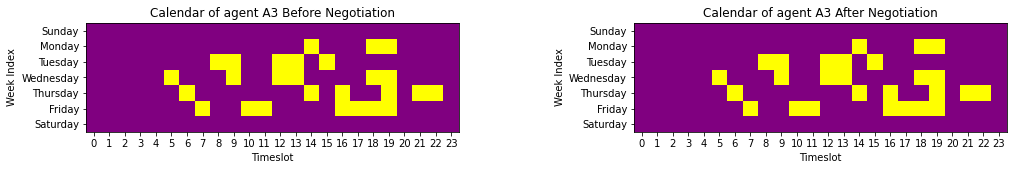

Calendar for agent A4 :


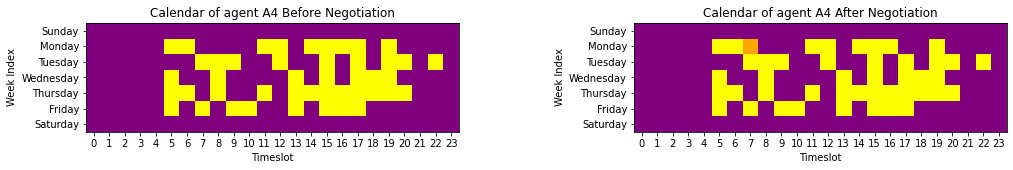

In [514]:
#If text contains a meeting request

if prediction == 0:
  
  #Convert datetime objects to timeslot:
  timeslot = get_slot_from_datetime(time, date)
  print('Timeslot:', timeslot)

  if timeslot in initiator_free_slots:
    print_on = True
    preference_on = True
    round = 0

    initiate_2_negotiation(initiator, attendees, timeslot, agents, meetings)
    if print_on:
      print()
      print('--------------------------------------------------')
      print('--------------------------------------------------')
      print()
      print('PROCESS HAS ENDED')
      print('TOTAL ROUNDS OF NEGOTIATION:',round)
      print()
      print('--------------------------------------------------')
      print('--------------------------------------------------')
    
    #Plot the calendars
    agent_list = list(agents.keys())
    calendars_after = meetings_to_plots(meetings, agent_list, (7,24))
    
    
    for key in calendars_after.keys():
      print('Calendar for agent',key, ':')
      #plt.imshow(calendars_after[key])
      f = plt.figure(figsize=(18,2))
      f.add_subplot(1,2, 1)
      plt.title('Calendar of agent {} Before Negotiation'.format(key))
      plt.imshow(pref_dict[key]['7x24'], interpolation='nearest',
                        cmap=cmap, norm=norm)
      plt.yticks(ticks = list(range(7)), labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
      plt.xticks(ticks = list(range(24)),labels =  list(range(24)))
      plt.xlabel('Timeslot')
      plt.ylabel('Week Index')

      f.add_subplot(1,2, 2)
      plt.title('Calendar of agent {} After Negotiation'.format(key))
      plt.imshow(calendars_after[key], interpolation='nearest',
                      cmap=cmap, norm=norm)

      plt.yticks(ticks = list(range(7)), labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
      plt.xticks(ticks = list(range(24)),labels =  list(range(24)))
      plt.xlabel('Timeslot')
      plt.ylabel('Week Index')
      plt.show(block=True)


  else:
    print('Timeslot is not available')

In [515]:
new_id ='M'+ str(max([get_number_from_key(key) for key in meetings.keys()]))
meetings[new_id]

{'attendees': ['A1', 'A2', 'A0'],
 'initiator': 'A0',
 'timeslots': [['41', 'CONFIRMED']]}

In [516]:
# body  = 'Upcoming board meeting in one week'

# date = date_from_text(body)
# time = time_from_text(body)
# print(100*'-')
# print('Date:', date)
# print(100*'-')
# print()
# print(100*'-')
# print('Time:', time)
# print(100*'-')



In [517]:
meetings

{'M0': {'attendees': ['A3', 'A1', 'A4', 'A2'],
  'initiator': 'A4',
  'timeslots': [['77', 'CONFIRMED']]},
 'M1': {'attendees': ['A1', 'A3', 'A0', 'A4', 'A2'],
  'initiator': 'A3',
  'timeslots': [['137', 'CONFIRMED']]},
 'M10': {'attendees': ['A4', 'A1', 'A3', 'A0'],
  'initiator': 'A0',
  'timeslots': [['110', 'CONFIRMED']]},
 'M11': {'attendees': ['A3', 'A4', 'A2'],
  'initiator': 'A2',
  'timeslots': [['102', 'CONFIRMED']]},
 'M12': {'attendees': ['A1', 'A3', 'A4', 'A2', 'A0'],
  'initiator': 'A1',
  'timeslots': [['90', 'CONFIRMED']]},
 'M13': {'attendees': ['A2', 'A4', 'A3', 'A1', 'A0'],
  'initiator': 'A0',
  'timeslots': [['43', 'CONFIRMED']]},
 'M14': {'attendees': ['A1', 'A2'],
  'initiator': 'A1',
  'timeslots': [['83', 'CONFIRMED']]},
 'M15': {'attendees': ['A1', 'A2', 'A0', 'A3', 'A4'],
  'initiator': 'A1',
  'timeslots': [['38', 'CONFIRMED']]},
 'M16': {'attendees': ['A1', 'A2', 'A3', 'A0'],
  'initiator': 'A0',
  'timeslots': [['84', 'CONFIRMED']]},
 'M17': {'attendees':